In [15]:
from PIL import Image
import os
import glob
from keras.preprocessing import image
import keras.preprocessing
import tensorflow as tf

In [16]:
train_gen = image.ImageDataGenerator(
    rescale = 1/255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_gen = image.ImageDataGenerator(rescale=1/255.0)

In [17]:
train_generator = train_gen.flow_from_directory(
    r"D:\\Github\\Oral-cancer\\Phase 1\\Tongue\\Train\\",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 139 images belonging to 2 classes.


In [18]:
train_generator.class_indices

{'Cancer': 0, 'Non Cancer': 1}

In [19]:
val_generator = test_gen.flow_from_directory(
    r"D:\\Github\\Oral-cancer\\Phase 1\\Tongue\\Val\\",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 8 images belonging to 2 classes.


In [20]:
# Create the VGG16 models

from keras.applications.vgg16 import VGG16
import keras
from keras.layers import *
from keras.models import Model 
import matplotlib.pyplot as plt

In [39]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in model.layers:
    layer.trainable=False

In [40]:
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(64,activation='relu')(av1)
d1 = Dropout(0.6)(fc1)
fc2 = Dense(1,activation='softmax')(d1)
model_new = Model(model.input,fc2)
model_new.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [41]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_new.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [44]:
hist = model_new.fit(
    train_generator,
    steps_per_epoch = 4,
    epochs = 10,
    batch_size=16,
    validation_data = val_generator,
)

Epoch 1/10


C:\Users\anupa\anaconda3\envs\Oral\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4/4 [==============================] - 4s 820ms/step - loss: 0.5395 - accuracy: 0.4673 - val_loss: 0.4329 - val_accuracy: 0.6250
Epoch 2/10
4/4 [==============================] - 4s 987ms/step - loss: 0.4870 - accuracy: 0.4393 - val_loss: 0.3952 - val_accuracy: 0.6250
Epoch 3/10
4/4 [==============================] - 4s 757ms/step - loss: 0.5146 - accuracy: 0.4299 - val_loss: 0.3771 - val_accuracy: 0.6250
Epoch 4/10
4/4 [==============================] - 4s 801ms/step - loss: 0.5490 - accuracy: 0.4206 - val_loss: 0.3866 - val_accuracy: 0.6250
Epoch 5/10
4/4 [==============================] - 3s 913ms/step - loss: 0.4555 - accuracy: 0.4393 - val_loss: 0.3937 - val_accuracy: 0.6250
Epoch 6/10
4/4 [==============================] - 4s 907ms/step - loss: 0.4801 - accuracy: 0.4673 - val_loss: 0.3849 - val_accuracy: 0.6250
Epoch 7/10
4/4 [==============================] - 4s 744ms/step - loss: 0.4780 - accuracy: 0.4393 - val_loss: 0.3662 - val_accuracy: 0.6250
Epoch 8/10
4/4 [===============

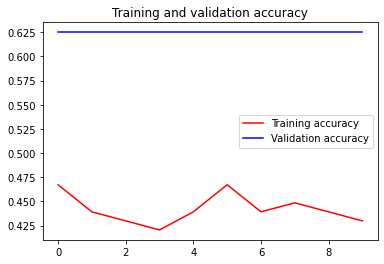

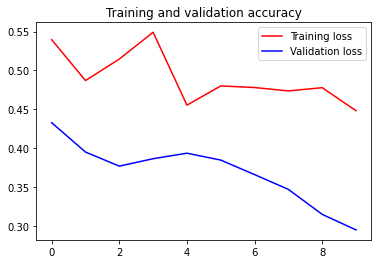

In [46]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(loc=0)
plt.title('Training and validation accuracy')

plt.show()